In [1]:
from google.colab import drive
drive.mount('./MyDrive')

Drive already mounted at ./MyDrive; to attempt to forcibly remount, call drive.mount("./MyDrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
# font_path = "C:/Windows/Fonts/NGULIM.TTF"
# font = fm.FontProperties(fname=font_path).get_name()
# rc('font', family=font)
plt.rc('font', family='NanumBarunGothic')
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

In [3]:
path = '/content/MyDrive/MyDrive/2021-2 데이터애널리틱스/'
# path = "./Dataset/"

# # is zero
# isZero = pd.read_csv(path+"da_data.csv")

# # no zero 
# noZero = pd.read_csv(path+"da_data_nozero.csv")

# new features 
nf_peppers = pd.read_csv(path+"건고추Model.csv", encoding='cp949', engine='python')
nf_green_onion = pd.read_csv(path+"대파Model.csv", encoding='cp949', engine='python')
nf_garlic = pd.read_csv(path+"마늘Model.csv", encoding='cp949', engine='python')
nf_radish = pd.read_csv(path+"무Model.csv", encoding='cp949', engine='python')
nf_cabbage = pd.read_csv(path+"배추Model.csv", encoding='cp949', engine='python')

In [4]:
X_column_pepper = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '건고추거래량', '건고추생산량', '건고추저장이월량', '건고추수입량', '건고추수입금액',
       '건고추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_pepper = '건고추가격'

X_column_green_onion = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '대파거래량', '대파생산량', '대파저장이월량', '대파수입량', '대파수입금액',
       '대파재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_green_onion = '대파가격'

X_column_garlic = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '마늘거래량', '마늘생산량', '마늘저장이월량', '마늘수입량', '마늘수입금액',
       '마늘재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_garlic = '마늘가격'

X_column_radish = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '무거래량', '무생산량', '무저장이월량', '무수입량', '무수입금액',
       '무재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_radish = '무가격'

X_column_cabbage = ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속',
       '최대풍속', '배추거래량', '배추생산량', '배추저장이월량', '배추수입량', '배추수입금액',
       '배추재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세',
       '공공서비스', '개인서비스', '근원물가', '생활물가']
y_column_cabbage = '배추가격'

In [117]:
def pre_processing(data) :
    scaler = MinMaxScaler()
    scale_cols = data.iloc[:,1:].columns
    
    data.sort_index(ascending=False).reset_index(drop=True)
    
    scaled = scaler.fit_transform(data[scale_cols])
    scaled = pd.DataFrame(scaled)
    scaled.columns = scale_cols
    
    return scaled


def get_data_split(data, X_column, y_column) :
    train_X, test_X, train_y, test_y = train_test_split(
    data[X_column], 
    data[y_column],
    test_size=0.2,
    shuffle=True,   # random split 
    random_state=42) # seed 고정, same sampling 
    
    return train_X, test_X, train_y, test_y


def gridsearchCV (model, parameters, X_train, y_train) :
    grid = GridSearchCV(model, param_grid = parameters, scoring='accuracy', cv=2) # cv is fold num
    grid.fit(X_train, y_train)
    
    print('GridSearchCV 최적 하이퍼 파라미터 :', grid.best_params_)
    print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid.best_score_))
    print('GridSearchCV 최적 하이퍼 파라미터로 학습된 Esimator 반환')
    
    return grid.best_estimator_


def feature_importance(model_xgb) : 
    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)


def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()


def build_model(train_dataset):
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(train_dataset.shape[1], train_dataset.shape[2])),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                optimizer=Adam(learning_rate=0.001), 
                metrics=['mae', 'mse'])
    
    return model

In [118]:
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# window_size만큼 데이터를 잘라 이어붙여주는 함수
def make_dataset(data, label, window_size):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
      feature_list.append(np.array(data.iloc[i:i+window_size]))
      label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)



def ts_train_test(data, window_size, name): 
    train = data[:round(len(data) * 0.8)].iloc[:, 1:]
    test = data[round(len(data) * 0.8):].iloc[:, 1:]

    scaler = MinMaxScaler()
    scale_cols = data.iloc[:, 1:data.shape[1]].columns.tolist() # 날짜, label 제외한 모든 변수
    print('scale_cols : ', scale_cols)

    scaled_train = scaler.fit_transform(train[scale_cols])
    scaled_test = scaler.transform(test[scale_cols])
    scaled_train = pd.DataFrame(scaled_train)
    scaled_test = pd.DataFrame(scaled_test)
    scaled_train.columns = scale_cols
    scaled_test.columns = scale_cols

    feature_cols = scaled_train.iloc[:, :scaled_train.shape[1]].columns.tolist()
    label_cols = scaled_test.iloc[:, scaled_test.shape[1]-1:].columns.tolist()
    print('feature : ', feature_cols, '\nlabel : ', label_cols)

    train_feature = scaled_train[feature_cols]
    train_label = scaled_train[label_cols]

    train_feature, train_label = make_dataset(train_feature, train_label, window_size)

    train_X, valid_X, train_y, valid_y = train_test_split(train_feature, train_label, test_size=0.2)
    
    test_feature = scaled_test[feature_cols]
    test_label = scaled_test[label_cols]

    test_X, test_y = make_dataset(test_feature, test_label, window_size)

    print(train_X.shape, valid_X.shape, test_X.shape, train_y.shape, valid_y.shape, test_y.shape)

    return train_feature, train_X, test_X, valid_X, train_y, test_y, valid_y

In [119]:
# input_data = pre_processing(nf_garlic)
# train_X, test_X, train_y, test_y = get_data_split(input_data, X_column_garlic, y_column_garlic)

feature, train_X, test_X, valid_X, train_y, test_y, valid_y = ts_train_test(nf_garlic, 7, "마늘가격")

scale_cols :  ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속', '최대풍속', '마늘거래량', '마늘생산량', '마늘저장이월량', '마늘수입량', '마늘수입금액', '마늘재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세', '공공서비스', '개인서비스', '근원물가', '생활물가', '마늘가격']
feature :  ['평균강수량', '최대강수량', '평균기온', '최고기온', '최저기온', '평균습도', '최저습도', '평균풍속', '최대풍속', '마늘거래량', '마늘생산량', '마늘저장이월량', '마늘수입량', '마늘수입금액', '마늘재배면적', '고급휘발유', '보통휘발유', '자동차용경유', '소비자물가지수', '농축수산물', '공업제품', '집세', '공공서비스', '개인서비스', '근원물가', '생활물가', '마늘가격'] 
label :  ['마늘가격']
(1369, 7, 27) (343, 7, 27) (423, 7, 27) (1369, 1) (343, 1) (423, 1)


In [120]:
# sns.pairplot(train_X[["마늘거래량", "평균강수량", "평균기온", "최대강수량"]], diag_kind="kde")

In [121]:
model_rnn = build_model(feature)

model_rnn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 7, 64)             1792      
                                                                 
 dense_27 (Dense)            (None, 7, 64)             4160      
                                                                 
 dense_28 (Dense)            (None, 7, 1)              65        
                                                                 
Total params: 6,017
Trainable params: 6,017
Non-trainable params: 0
_________________________________________________________________


In [122]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 500

early_stop = EarlyStopping(monitor='val_loss', patience=15) # 조기종료 조건
model_path = path+'model/'
filename = os.path.join(model_path, 'checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model_rnn.fit(
  train_X, train_y,
  epochs=EPOCHS, validation_data=(valid_X, valid_y), verbose=0, 
  callbacks=[early_stop, checkpoint])

#model_rnn.fit(train_X, train_y, epochs=EPOCHS, validation_split=0.2, verbose = 1, batch_size = 1, )


Epoch 00001: val_loss improved from inf to 0.02516, saving model to /content/MyDrive/MyDrive/2021-2 데이터애널리틱스/model/checkpoint.h5

Epoch 00002: val_loss improved from 0.02516 to 0.01328, saving model to /content/MyDrive/MyDrive/2021-2 데이터애널리틱스/model/checkpoint.h5

Epoch 00003: val_loss improved from 0.01328 to 0.00999, saving model to /content/MyDrive/MyDrive/2021-2 데이터애널리틱스/model/checkpoint.h5

Epoch 00004: val_loss improved from 0.00999 to 0.00876, saving model to /content/MyDrive/MyDrive/2021-2 데이터애널리틱스/model/checkpoint.h5

Epoch 00005: val_loss improved from 0.00876 to 0.00834, saving model to /content/MyDrive/MyDrive/2021-2 데이터애널리틱스/model/checkpoint.h5

Epoch 00006: val_loss improved from 0.00834 to 0.00784, saving model to /content/MyDrive/MyDrive/2021-2 데이터애널리틱스/model/checkpoint.h5

Epoch 00007: val_loss did not improve from 0.00784

Epoch 00008: val_loss improved from 0.00784 to 0.00749, saving model to /content/MyDriv

In [108]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
11,0.229377,0.4384,0.229377,0.21597,0.422815,0.21597,11
12,0.229377,0.4384,0.229377,0.21597,0.422815,0.21597,12
13,0.229377,0.4384,0.229377,0.21597,0.422815,0.21597,13
14,0.229377,0.4384,0.229377,0.21597,0.422815,0.21597,14
15,0.229377,0.4384,0.229377,0.21597,0.422815,0.21597,15


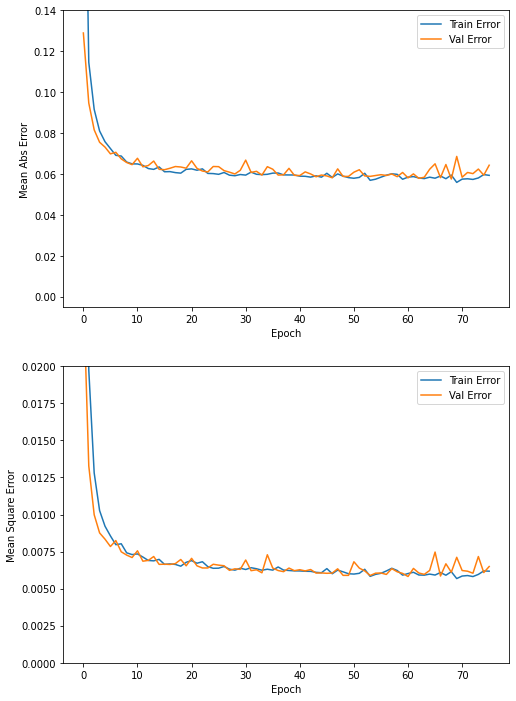

In [123]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure(figsize=(8,12))
    
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([-0.005,0.14])
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,0.02])
    plt.legend()
    plt.show()

plot_history(history)

In [124]:
# test set data를 통해 모델이 실전에 투입되었을 때 모델의 성능을 예측
loss, mae, mse = model_rnn.evaluate(test_X, test_y, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f}".format(mae))

14/14 - 0s - loss: 0.0204 - mae: 0.1080 - mse: 0.0204 - 34ms/epoch - 2ms/step
테스트 세트의 평균 절대 오차:  0.11


In [130]:
pred_rnn.reshape(-1,1).shape

(2961, 1)

ValueError: ignored

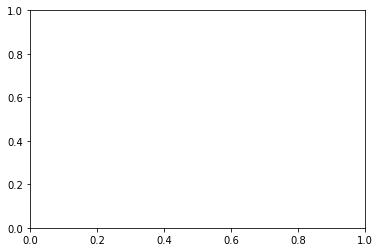

In [101]:
pred_rnn = model_rnn.predict(test_X).flatten()

plt.scatter(test_y, pred_rnn)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

In [ ]:
error = pred_rnn - test_y
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [ ]:
df_result = pd.DataFrame(list(zip(test_y, pred_rnn)), columns=['true_y', 'rnn_pred_y'])
df_result 

In [ ]:
# rmse
mse = mean_squared_error(test_y, pred_rnn)
print("mse:  %f" % mse)

rmse = np.sqrt(mse)
print("rmse: %f" %rmse)

In [ ]:
true_y=test_y.to_numpy()

graph(pred_rnn, true_y)